In [1]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
engine = author.raw_engine

In [2]:
df = pd.read_sql("SELECT * FROM BTCUSD_2m",engine)
df.set_index('Datetime',inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-02-03 03:04:00,36994.378906,36997.386719,36994.378906,36997.386719,36997.386719,15951872
2022-02-03 03:06:00,36989.128906,36992.972656,36989.128906,36992.972656,36992.972656,1249280
2022-02-03 03:08:00,36988.531250,36988.531250,36985.875000,36985.875000,36985.875000,0
2022-02-03 03:10:00,36978.066406,36978.066406,36972.609375,36972.609375,36972.609375,970752
2022-02-03 03:12:00,36970.988281,36970.988281,36954.027344,36954.027344,36954.027344,999424
...,...,...,...,...,...,...
2022-03-03 02:54:00,43766.308594,43772.703125,43766.308594,43772.703125,43772.703125,794624
2022-03-03 02:56:00,43760.609375,43781.710938,43760.609375,43781.710938,43781.710938,11143168
2022-03-03 02:58:00,43806.292969,43806.292969,43806.292969,43806.292969,43806.292969,8454144


<AxesSubplot:>

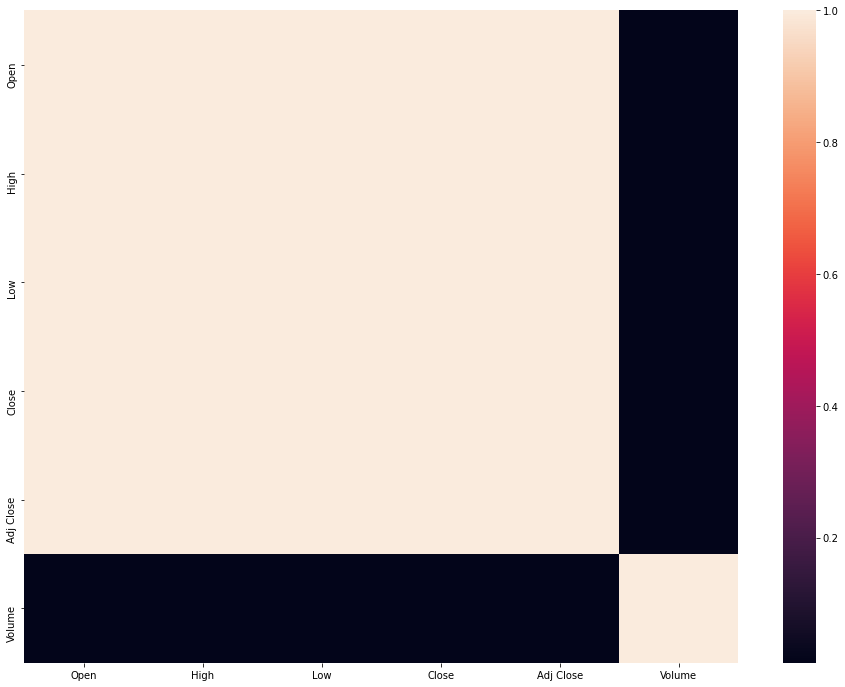

In [3]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr())

o,h,l,c는 실상 동일하므로 피쳐를 조합해 새로운 피쳐를 만들어준다.

In [4]:
gap = (df['High'] - df['Low'])
df['Gap'] = gap
df

,Open,High,Low,Close,Adj Close,Volume,Gap
Datetime,,,,,,,
2022-02-03 03:04:00,36994.378906,36997.386719,36994.378906,36997.386719,36997.386719,15951872,3.007812
2022-02-03 03:06:00,36989.128906,36992.972656,36989.128906,36992.972656,36992.972656,1249280,3.843750
2022-02-03 03:08:00,36988.531250,36988.531250,36985.875000,36985.875000,36985.875000,0,2.656250
2022-02-03 03:10:00,36978.066406,36978.066406,36972.609375,36972.609375,36972.609375,970752,5.457031
2022-02-03 03:12:00,36970.988281,36970.988281,36954.027344,36954.027344,36954.027344,999424,16.960938
...,...,...,...,...,...,...,...
2022-03-03 02:54:00,43766.308594,43772.703125,43766.308594,43772.703125,43772.703125,794624,6.394531
2022-03-03 02:56:00,43760.609375,43781.710938,43760.609375,43781.710938,43781.710938,11143168,21.101562
2022-03-03 02:58:00,43806.292969,43806.292969,43806.292969,43806.292969,43806.292969,8454144,0.000000


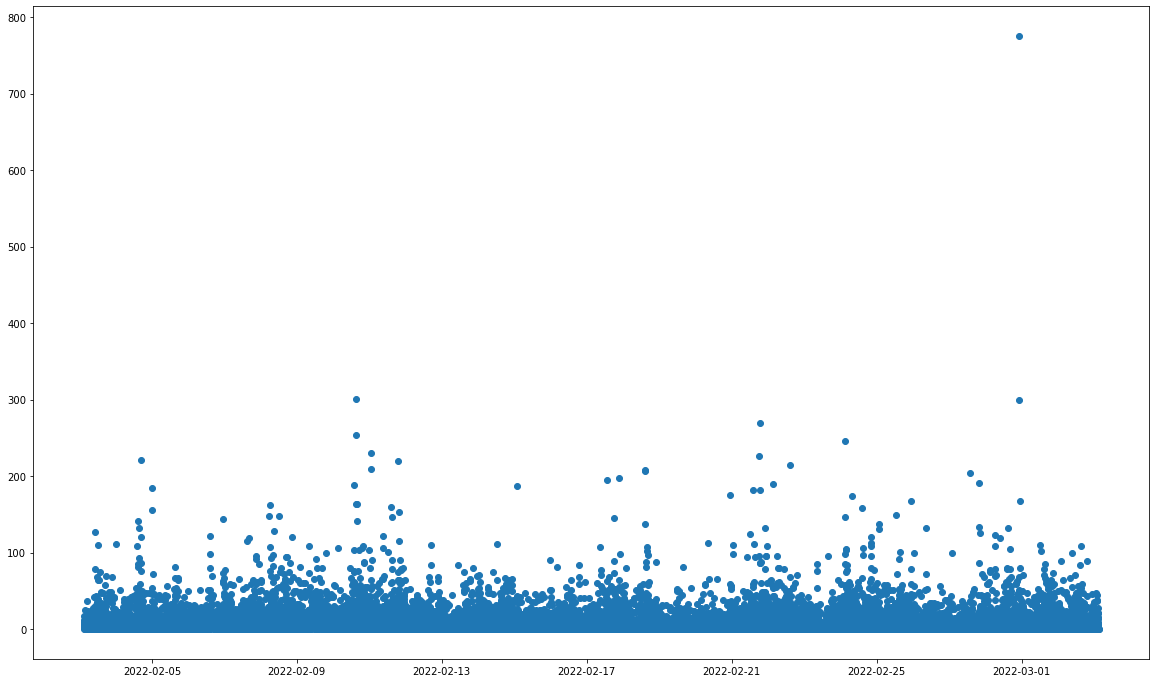

In [5]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

값이 커짐에 따라 변동폭도 증가하므로 명확한 아웃라이어를 보기위해 비트코인의 가격 상승을 반영해준다.

In [6]:
df['Gap'] = df['Gap'] / df['Low']

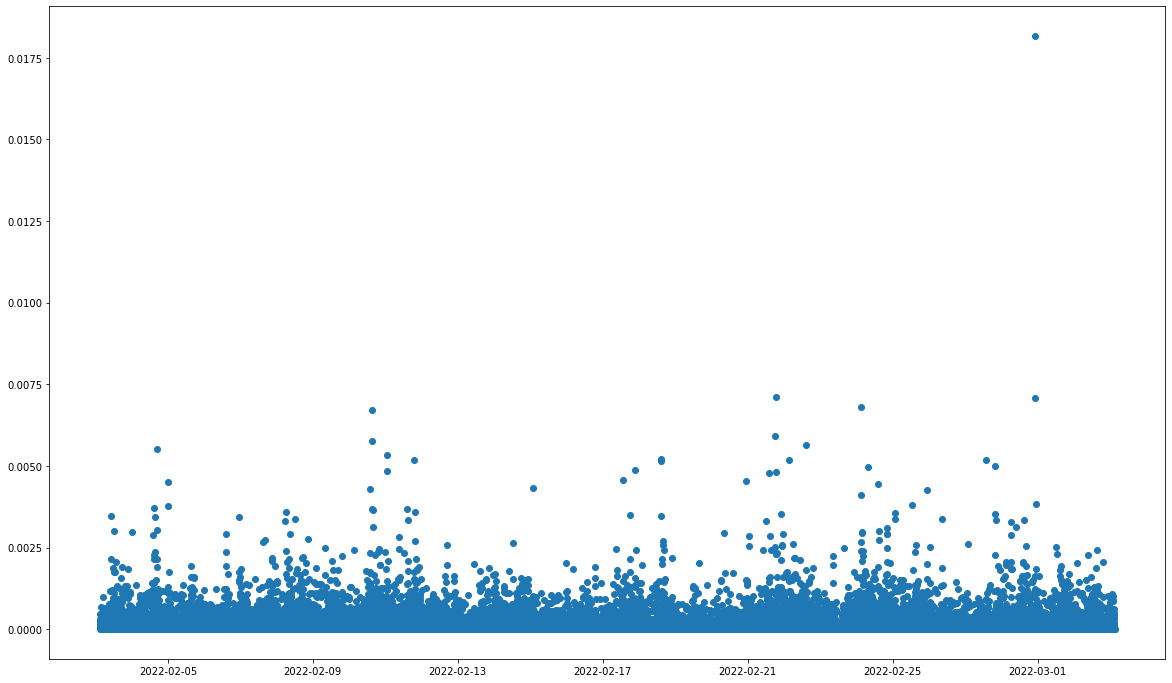

In [7]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

In [8]:
def get_macd(df):
    price = df['Adj Close']
    exp12 = price.ewm(span = 12, adjust=False).mean()
    exp26 = price.ewm(span = 26, adjust=False).mean()
    macd = exp12 - exp26
    exp = macd.ewm(span=9,adjust=False).mean()
    return exp

def get_rsi(df, period):
    close_price = df['Close']
    delta = close_price.diff()
    gains,drops = delta.copy(),delta.copy()
    gains[gains < 0] = 0
    drops[drops > 0] = 0
    au = gains.ewm(com=period-1, min_periods=period).mean()
    ad = drops.abs().ewm(com=period-1, min_periods=period).mean()
    rs = au / ad
    rsi = pd.Series(100 - (100 / (1 + rs)))
    return rsi

def get_vwap(df):
    volumes = df['Volume']
    price = df['Adj Close']
    vwap = ((volumes * price).cumsum()) / volumes.cumsum()
    return vwap

In [9]:
df['VWAP'] = get_vwap(df)
df['RSI'] = get_rsi(df,14)
df['MACD'] = get_macd(df)
df

,Open,High,Low,Close,Adj Close,Volume,Gap,VWAP,RSI,MACD
Datetime,,,,,,,,,,
2022-02-03 03:04:00,36994.378906,36997.386719,36994.378906,36997.386719,36997.386719,15951872,0.000081,36997.386719,NaN,0.000000
2022-02-03 03:06:00,36989.128906,36992.972656,36989.128906,36992.972656,36992.972656,1249280,0.000104,36997.066136,NaN,-0.070424
2022-02-03 03:08:00,36988.531250,36988.531250,36985.875000,36985.875000,36985.875000,0,0.000072,36997.066136,NaN,-0.294375
2022-02-03 03:10:00,36978.066406,36978.066406,36972.609375,36972.609375,36972.609375,970752,0.000148,36995.759643,NaN,-0.813788
2022-02-03 03:12:00,36970.988281,36970.988281,36954.027344,36954.027344,36954.027344,999424,0.000459,36993.584089,NaN,-1.785773
...,...,...,...,...,...,...,...,...,...,...
2022-03-03 02:54:00,43766.308594,43772.703125,43766.308594,43772.703125,43772.703125,794624,0.000146,42290.901327,48.785858,-18.325712
2022-03-03 02:56:00,43760.609375,43781.710938,43760.609375,43781.710938,43781.710938,11143168,0.000482,42290.924760,50.820505,-16.553562
2022-03-03 02:58:00,43806.292969,43806.292969,43806.292969,43806.292969,43806.292969,8454144,0.000000,42290.942831,55.962219,-14.378639


In [10]:
df = df.dropna()
df = df.drop(['Open','Close','High','Low'], axis=1)
df


,Adj Close,Volume,Gap,VWAP,RSI,MACD
Datetime,,,,,,
2022-02-03 03:32:00,36909.417969,0,0.000128,36978.982746,16.830063,-10.851079
2022-02-03 03:34:00,36902.097656,8738816,0.000024,36964.191552,15.557577,-12.815320
2022-02-03 03:36:00,36899.984375,301056,0.000157,36963.768815,15.200278,-14.757981
2022-02-03 03:38:00,36908.300781,6270976,0.000205,36957.079181,22.721859,-16.418959
2022-02-03 03:40:00,36924.199219,19298304,0.000090,36948.179150,34.654437,-17.525241
...,...,...,...,...,...,...
2022-03-03 02:54:00,43772.703125,794624,0.000146,42290.901327,48.785858,-18.325712
2022-03-03 02:56:00,43781.710938,11143168,0.000482,42290.924760,50.820505,-16.553562
2022-03-03 02:58:00,43806.292969,8454144,0.000000,42290.942831,55.962219,-14.378639


<AxesSubplot:>

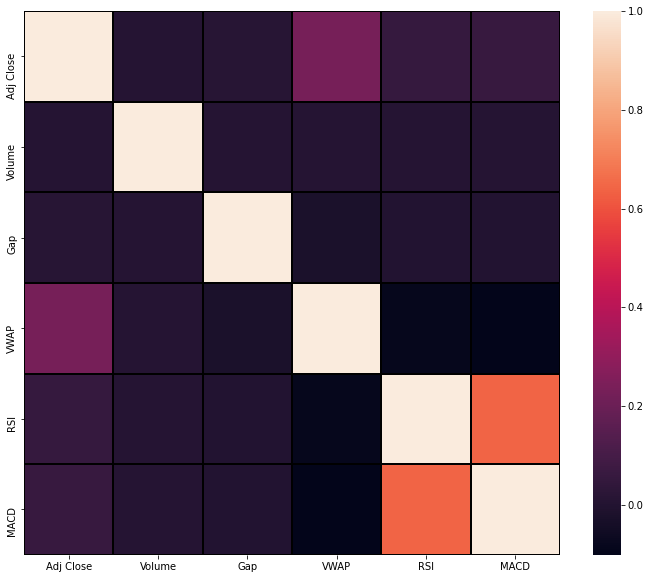

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),linewidth=1,linecolor='black')

vwap와 rsi가 음의 상관관계를 띄는 것을 확인할 수 있다. 또한 gap은 volume과 양의 상관 관계를 띄는데 이로써 거래량이 튀면 고점이 증가한다는 것을 확인할 수 있다.

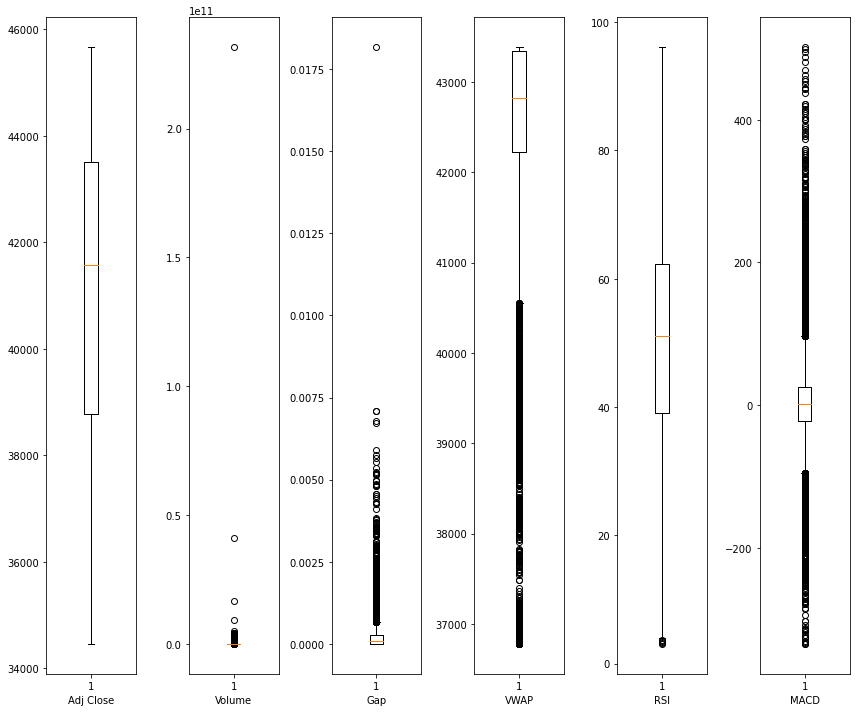

In [12]:
fig,axes = plt.subplots(1,6,figsize=(12,10))
for i, c in enumerate(df.columns,start=1):
    plt.subplot(1,6,i)
    plt.boxplot(df[c])
    plt.xlabel(c)
plt.tight_layout()

iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. gap, vwap, macd가 특히 심하다.


In [13]:
q_1 = df.apply(lambda x: np.quantile(x,0.25))
q_3 = df.apply(lambda x: np.quantile(x,0.75))
iqr = q_3 - q_1
min_p = q_1 - 2.5 * iqr
max_p = q_3 + 2.5 * iqr
print(min_p,max_p)

Adj Close    2.692172e+04
Volume      -4.199936e+07
Gap         -6.767619e-04
VWAP         3.943800e+04
RSI         -1.936689e+01
MACD        -1.425983e+02
dtype: float64 Adj Close    5.535548e+04
Volume       5.879910e+07
Gap          9.474666e-04
VWAP         4.613104e+04
RSI          1.207073e+02
MACD         1.450603e+02
dtype: float64


5분 단위 데이터라 그런지 volume이 0으로 잡히는 경우가 많다. 따라서 volume을 제외하고 이상치를 구해준다.

In [14]:
outliers = np.where((df < min_p) | (df > max_p))
outliers

(array([    0,     1,     2, ..., 19838, 19856, 19882]),
 array([3, 3, 3, ..., 2, 2, 1]))

In [15]:
len(outliers[0])

5608

In [16]:
from collections import defaultdict
row,col = outliers
outliers_cols = defaultdict(list)
for r,c in zip(row,col):
    outliers_cols[df.columns[c]].append(r)
outliers_cols

defaultdict(list,
            {'VWAP': [0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              10,
              11,
              12,
              13,
              14,
              15,
              16,
              17,
              18,
              19,
              20,
              21,
              22,
              23,
              24,
              25,
              26,
              27,
              28,
              29,
              30,
              31,
              32,
              33,
              34,
              35,
              36,
              37,
              38,
              39,
              40,
              41,
              42,
              43,
              44,
              45,
              46,
              47,
              48,
              49,
              50,
              51,
              52,
              53,
            

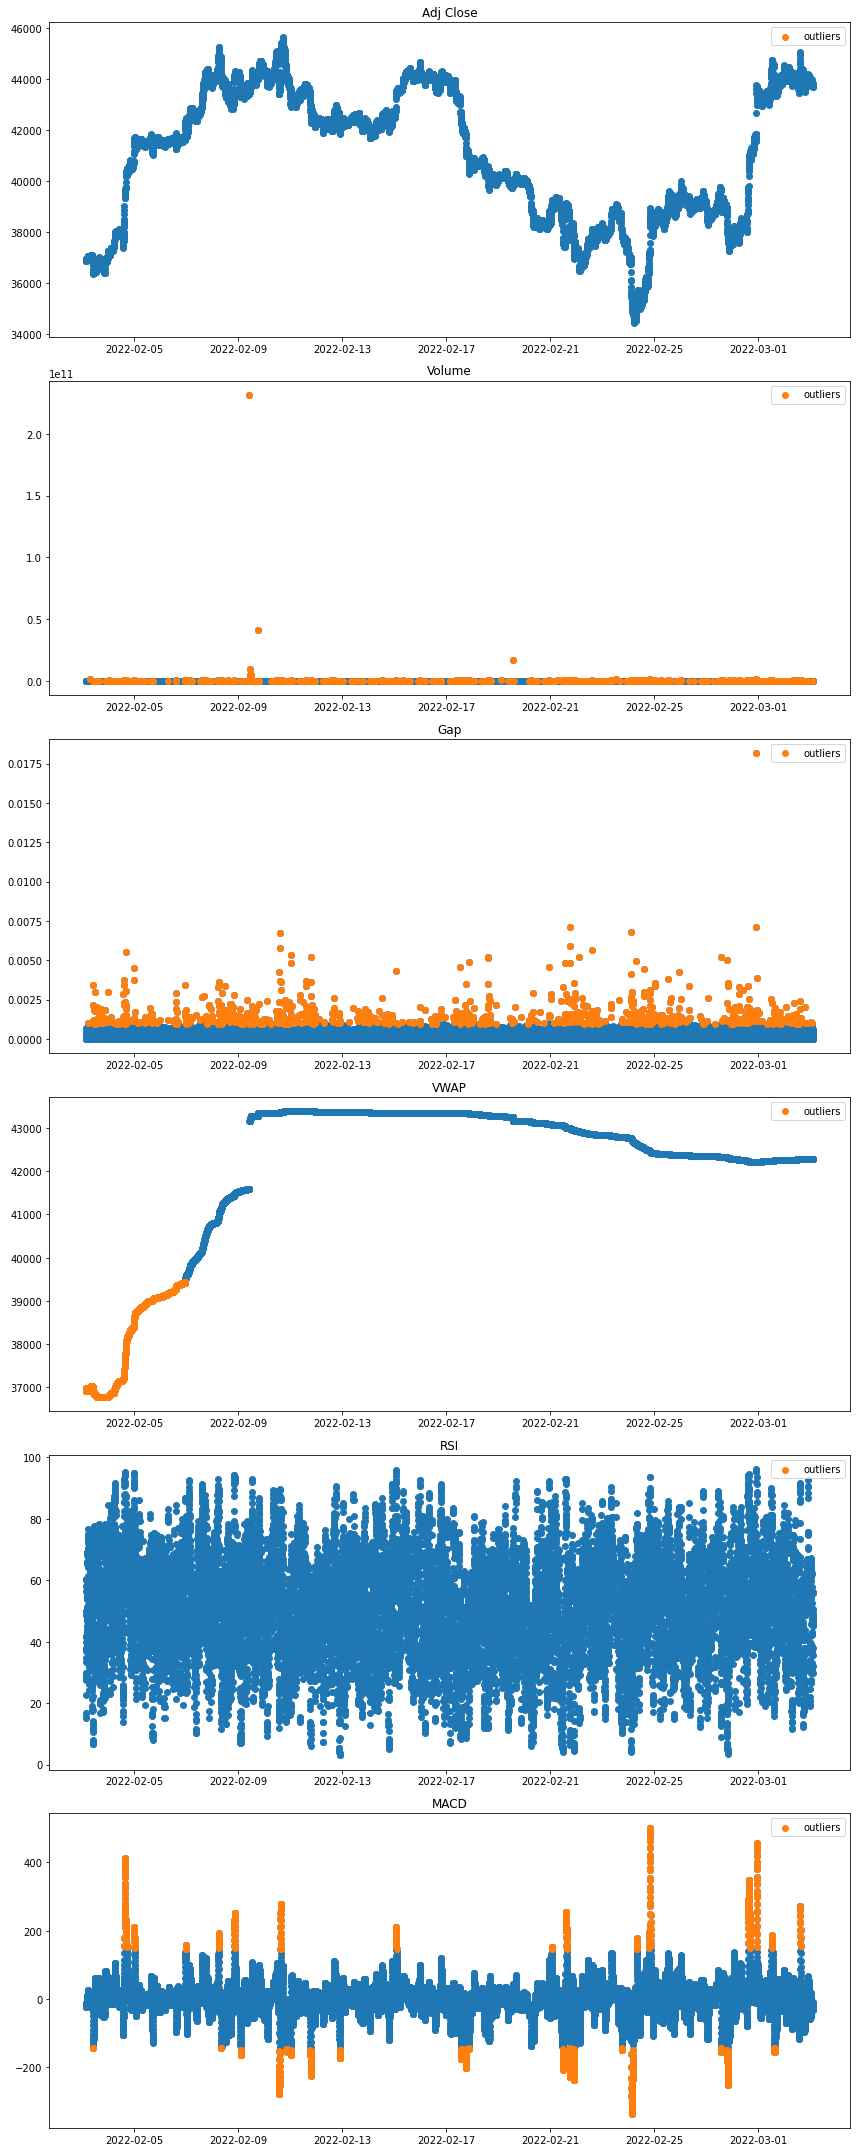

In [17]:
fig,axes = plt.subplots(6,1,figsize=(12,30))
for i, c in enumerate(df.columns,start=1):
    index = df[c].index
    plt.subplot(6,1,i)
    plt.title(c)
    plt.scatter(x=index,y=df[c])
    # if c!='Volume':
    plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
    plt.legend()
plt.tight_layout()

아웃라이어를 제거하는 것보다 포함하는 것이 5분 차트에 있어서는 더욱 예측도가 좋았다.


모델을 생성하고 비교해보자.

In [18]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42))
])
lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])
rf_model = Pipeline([
    ('std_scaler', StandardScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True))
])

In [19]:
def create_train_data(df):
    X = df.drop(['Adj Close','Volume'],axis=1)
    y = df['Adj Close'] #비트코인의 봉 평균가.
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=24)
    return train_X, test_X, train_y, test_y

In [20]:
train_X, test_X, train_y, test_y = create_train_data(df)

In [21]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 6140104.4161418555, alpha: 1000
mse: 6115213.439106109, alpha: 300
mse: 6069829.481719494, alpha: 100
mse: 6011279.324099079, alpha: 30
mse: 5999357.890169601, alpha: 10
mse: 6091897.437809619, alpha: 1
mse: 6634759.681007218, alpha: 1000
mse: 6363641.965426426, alpha: 300
mse: 6228084.639606077, alpha: 100
mse: 6165819.922672039, alpha: 30
mse: 6125788.101208068, alpha: 10


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11936934241.947594, tolerance: 9179484.417632822
  model = cd_fast.enet_coordinate_descent(


mse: 5973683.419997052, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11936934241.947594, tolerance: 9179484.417632822
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=4)),
                ('std_scaler', StandardScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [22]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.1f}')
    plt.legend()

In [23]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

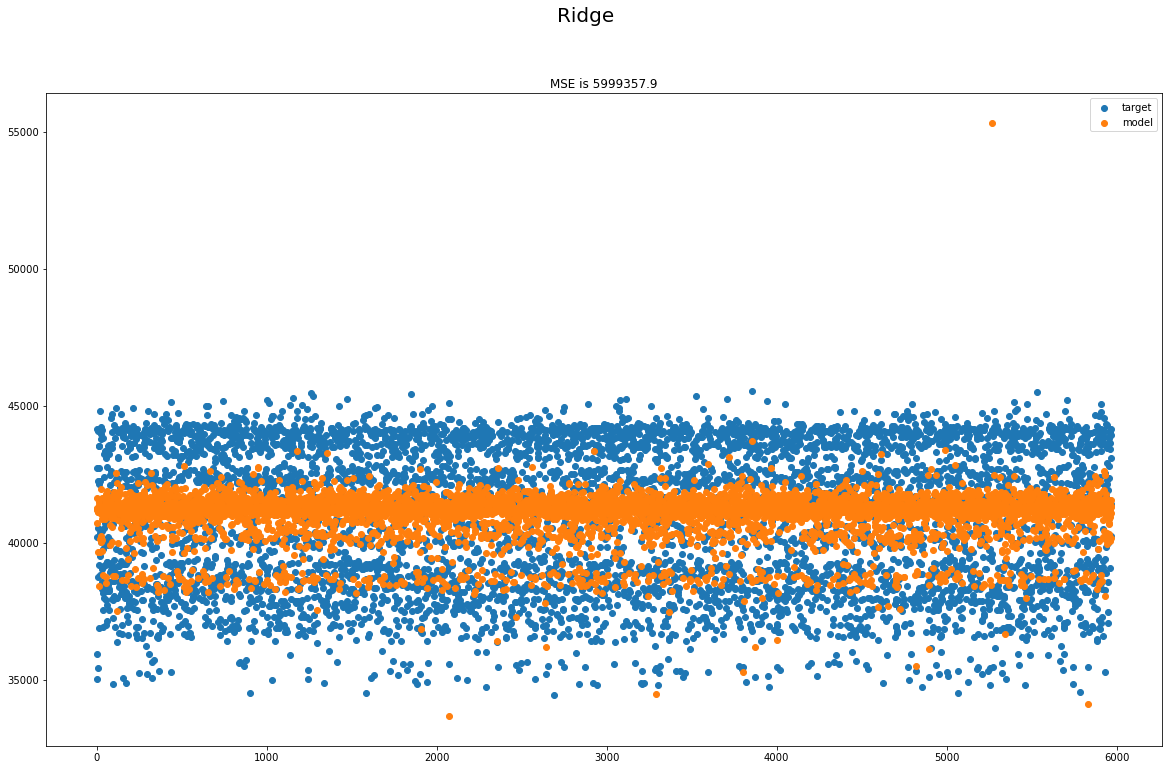

In [24]:
visualize(r_pred,test_y,"Ridge")

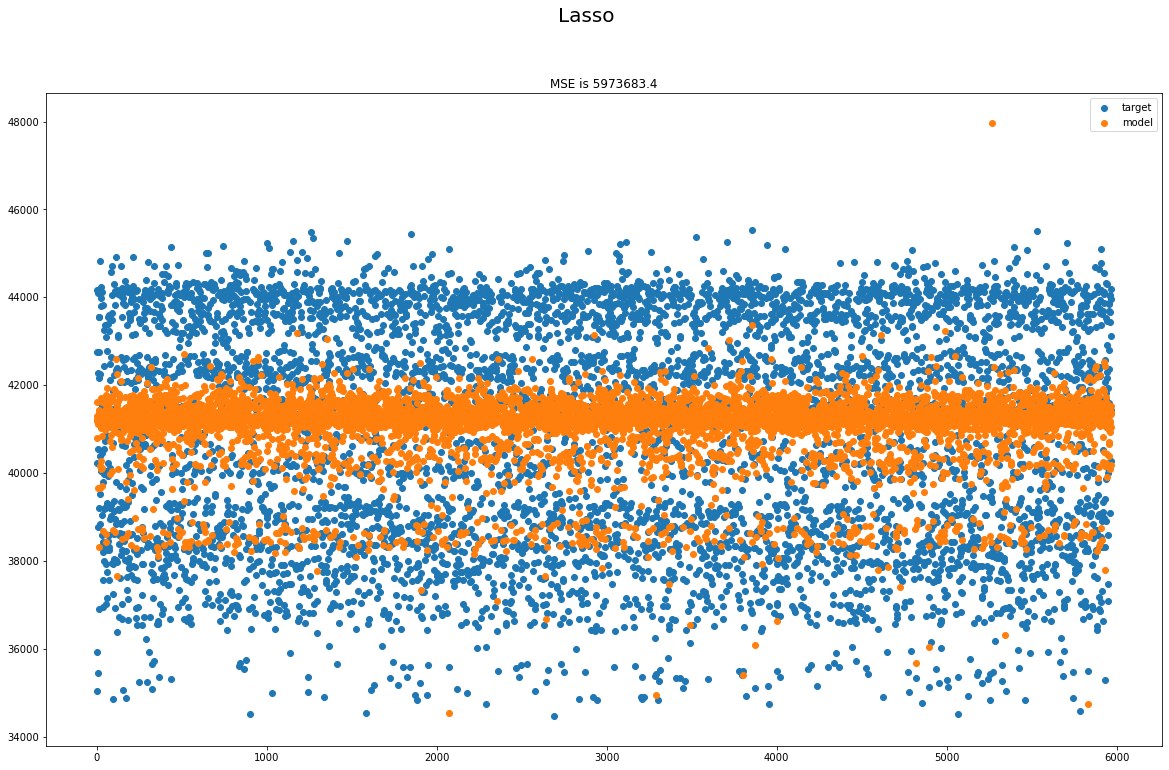

In [25]:
visualize(l_pred, test_y, "Lasso")

In [26]:
def visualize_plot(pred,target,name):
    pred = pd.Series(pred, index=target.index)
    plt.figure(figsize=(12,10))
    pred.sort_index().plot(label='model')
    test_y.sort_index().plot(label='target')
    plt.title(name)
    plt.legend()


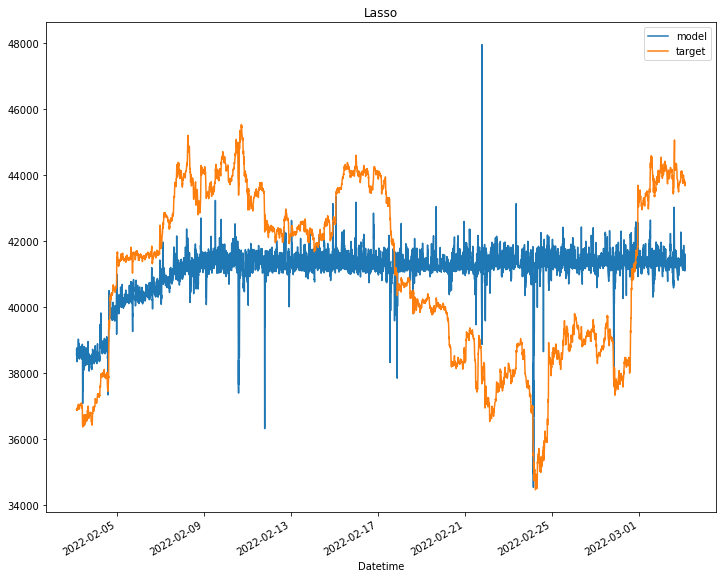

In [27]:
visualize_plot(l_pred, test_y, 'Lasso')

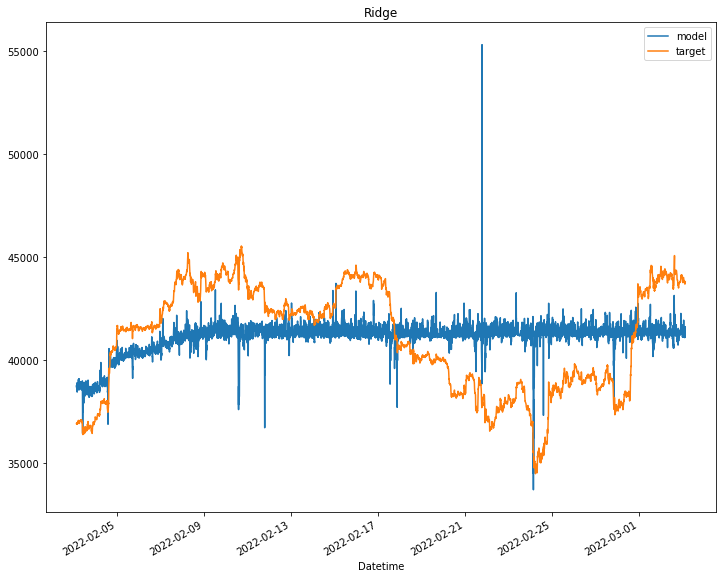

In [28]:
visualize_plot(r_pred, test_y, "Ridge")

In [34]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

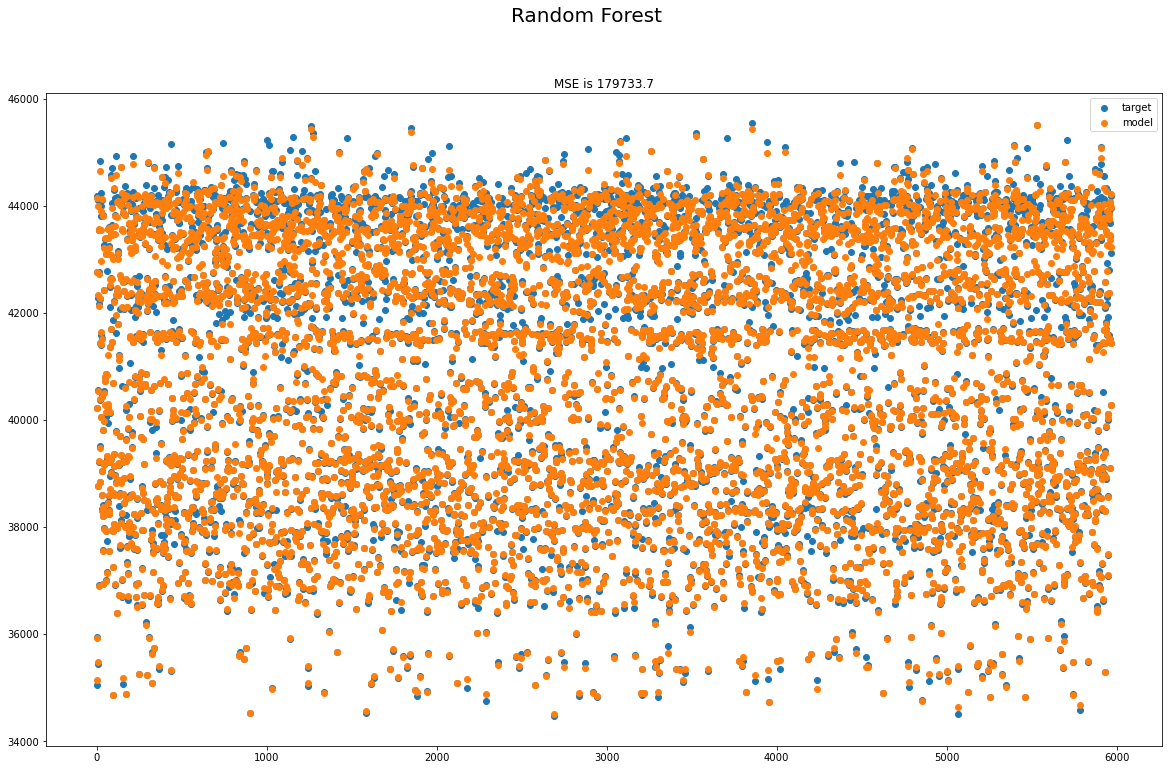

In [35]:
visualize(rf_pred, test_y, "Random Forest")

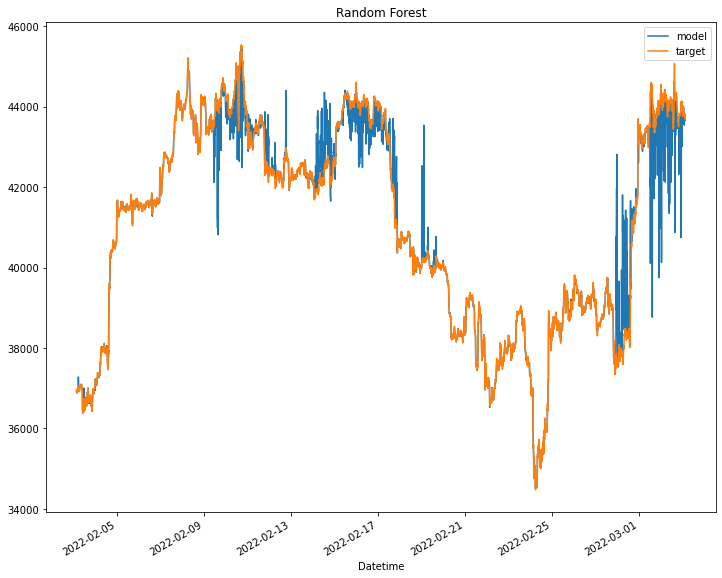

In [36]:
visualize_plot(rf_pred, test_y, "Random Forest")

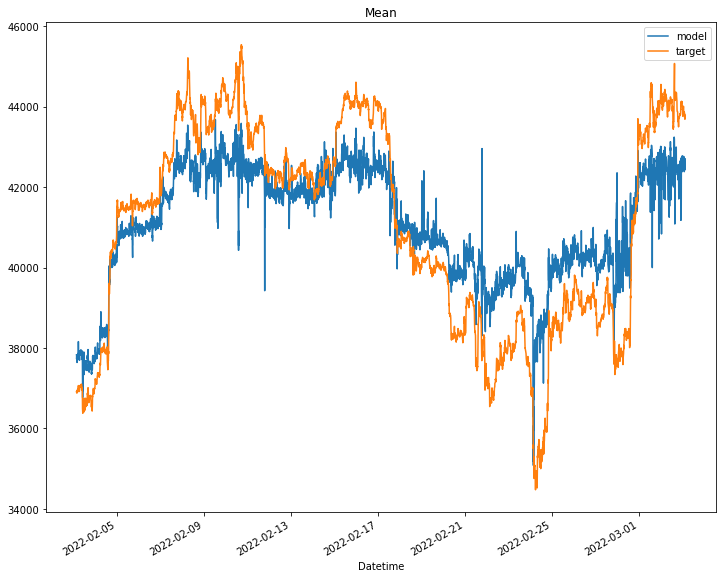

In [32]:
visualize_plot((l_pred + rf_pred)/2,test_y,"Mean")

In [33]:
from joblib import dump #모델을 저장한다.
dump(rf_model,'model/BTCUSD_RF_2m.joblib')


['model/BTCUSD_RF_2m.joblib']